In [1]:
import os
import random

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import re
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from typing import Any, List, Tuple

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
import torchvision.transforms as T
import sklearn.utils as utils

In [2]:
torch.cuda.empty_cache()
random_seed = 42
batch_size = 30
train_root = 'train_images'
NUM_EPOCHS = 35
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train_table = pd.read_csv('train.csv')
train_table.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
train_table.shape

(21396, 2)

In [5]:
train_table['label'].value_counts()

3    13158
4     2576
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [6]:
train_paths = [os.path.join(train_root, file) for file in train_table['image_id']]
train_labels = train_table['label'].values

In [7]:
normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )
preprocess = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

def default_loader(path):
    img_pil =  Image.open(path)
    img_pil = img_pil.resize((224,224))
    img_tensor = preprocess(img_pil)
    return img_tensor

C:\Users\woqip\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [8]:
class MyDataset(Dataset):
    def __init__(self, img_paths, labels, loader=default_loader):
        self.img_paths = img_paths
        self.labels = labels
        self.loader = loader
        
    def __getitem__(self, index):
        img_path, label = self.img_paths[index], self.labels[index]
        img = self.loader(img_path)
        
        return img, label
    
    def __len__(self):
        return len(self.labels)

In [9]:
dataset = MyDataset(train_paths, train_labels)
len(dataset)*np.array([0.8,0.05,0.15])

array([17116.8,  1069.8,  3209.4])

In [10]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [17118 ,  1070,  3208], generator=torch.Generator().manual_seed(random_seed))

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet121', pretrained=True)
model = model.to(device)

Using cache found in C:\Users\woqip/.cache\torch\hub\pytorch_vision_v0.9.0


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

Epoch: 001/035 | Batch 0000/0571 | Loss: 9.6845
Epoch: 001/035 | Batch 0100/0571 | Loss: 1.0978
Epoch: 001/035 | Batch 0200/0571 | Loss: 0.8262
Epoch: 001/035 | Batch 0300/0571 | Loss: 0.5041
Epoch: 001/035 | Batch 0400/0571 | Loss: 0.1818
Epoch: 001/035 | Batch 0500/0571 | Loss: 0.4252
Epoch: 001/035 | Train: 87.28% | Validation: 82.90%
Time elapsed: 9.69 min
Epoch: 002/035 | Batch 0000/0571 | Loss: 0.5468
Epoch: 002/035 | Batch 0100/0571 | Loss: 0.2164
Epoch: 002/035 | Batch 0200/0571 | Loss: 0.3802
Epoch: 002/035 | Batch 0300/0571 | Loss: 0.2085
Epoch: 002/035 | Batch 0400/0571 | Loss: 0.0410
Epoch: 002/035 | Batch 0500/0571 | Loss: 0.1847
Epoch: 002/035 | Train: 92.88% | Validation: 83.08%
Time elapsed: 21.25 min
Epoch: 003/035 | Batch 0000/0571 | Loss: 0.1840
Epoch: 003/035 | Batch 0100/0571 | Loss: 0.0667
Epoch: 003/035 | Batch 0200/0571 | Loss: 0.2448
Epoch: 003/035 | Batch 0300/0571 | Loss: 0.1073
Epoch: 003/035 | Batch 0400/0571 | Loss: 0.0310
Epoch: 003/035 | Batch 0500/0571 

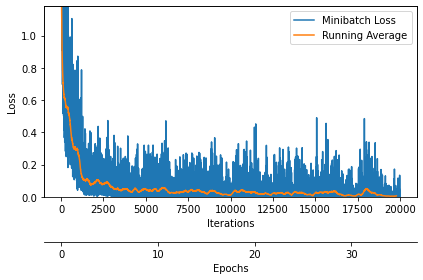

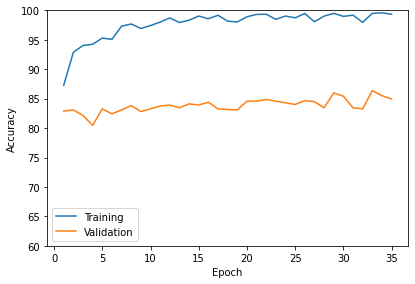

In [14]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [15]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  125728 KB |    4106 MB |  389913 GB |  389913 GB |
|       from large pool |   24750 KB |    3986 MB |  381252 GB |  381252 GB |
|       from small pool |  100977 KB |     124 MB |    8660 GB |    8660 GB |
|---------------------------------------------------------------------------|
| Active memory         |  125728 KB |    4106 MB |  389913 GB |  389913 GB |
|       from large pool |   24750 KB |    3986 MB |  381252 GB |

In [16]:
torch.cuda.empty_cache()